# Bitbrains Dataset Exploration

In [1]:
import matplotlib. pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from BitbrainsUtils import *

# change path in BitbrainsUtils.py if needed
random.seed(7)

figures saved to ../Figures/DataExploration/


## Generate a Figure per VM

In [3]:
# Load all VMs (list of VMs)
VMs = load_all_VMs()

## CPU Utilization

In [35]:
# CPU utilization
# New figure each VMs
for idx,VM in enumerate(VMs):
    save_path = os.path.join('Single VMs','CPU_utilization','VM{}'.format(idx))
    # Create the folder whether not exists
    if not os.path.exists(os.path.join(FIGURES_PATH, 'Single VMs','CPU_utilization')):
        os.makedirs(os.path.join(FIGURES_PATH, 'Single VMs','CPU_utilization'))
    plot_timeSeries(VM['CPU usage [MHZ]'],
                    MA=10,
                    ema=0.05,
                    legend=True,
                    title='CPU usage{}'.format(idx),
                    ylabel="CPU usage [MHZ]",
                    savefig=save_path)

### Memory utilization

In [36]:
# Memory utilization
# New figure each VMs
for idx,VM in enumerate(VMs):
    save_path = os.path.join('Single VMs','memory_utilization','VM{}'.format(idx))
    # Create the folder whether not exists
    if not os.path.exists(os.path.join(FIGURES_PATH, 'Single VMs','memory_utilization')):
        os.makedirs(os.path.join(FIGURES_PATH, 'Single VMs','memory_utilization'))
    plot_timeSeries(VM['Memory usage [%]'],
                    MA=10,
                    ema=0.05,
                    legend=True,
                    title='Memory usage{}'.format(idx),
                    ylabel="Memory usage [%]",
                    ylim=(0,125),
                    savefig= save_path)

In [38]:
# Memory utilization
# New figure each VMs
for idx,VM in enumerate(VMs):
    save_path = os.path.join('Single VMs','memory_utilization_noFilter','VM{}'.format(idx))
    # Create the folder whether not exists
    if not os.path.exists(os.path.join(FIGURES_PATH, 'Single VMs','memory_utilization_noFilter')):
        os.makedirs(os.path.join(FIGURES_PATH, 'Single VMs','memory_utilization_noFilter'))
    plot_timeSeries(VM['Memory usage [KB]'],
                    MA=0,
                    ema=0,
                    legend=True,
                    title='Memory usage{}'.format(idx),
                    ylabel="Memory usage [KB]",
                    ylim=(0,125),
                    savefig= save_path)

## Duration of jobs

In [4]:
(VMs[0].index[len(VMs[0])-1] - VMs[0].index[0])

Timedelta('29 days 23:59:12')

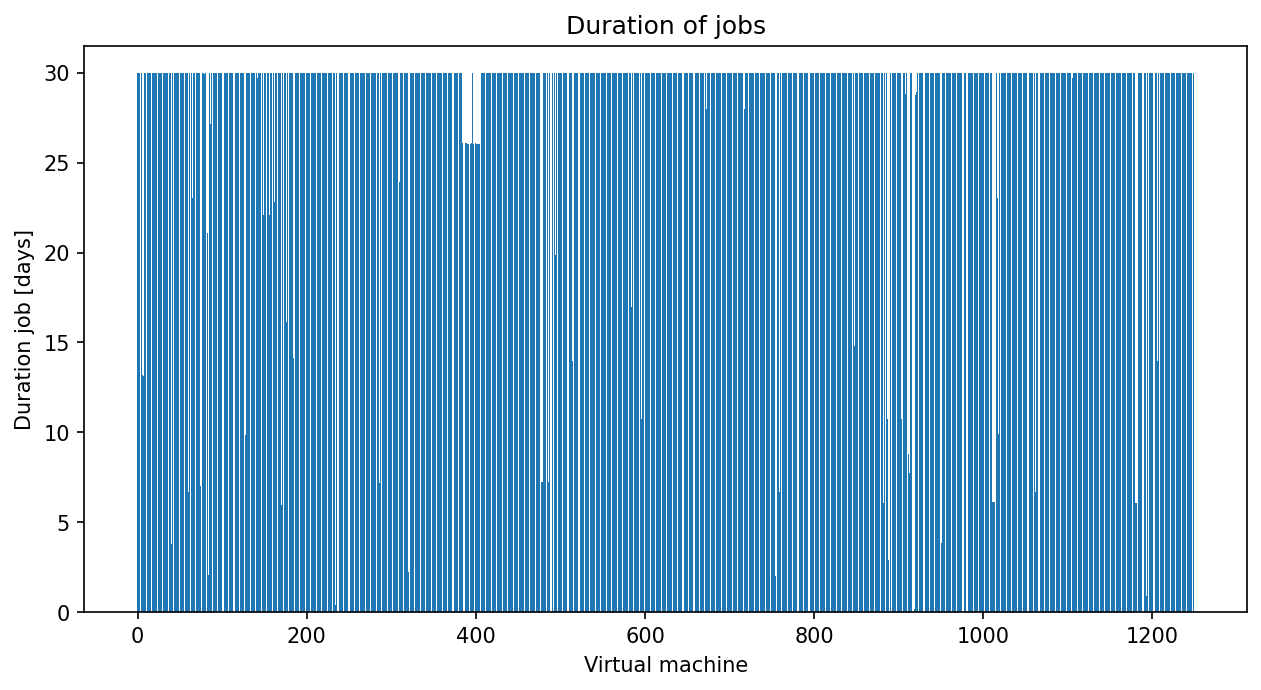

In [11]:
# Get all the series
duration_jobs = np.zeros(len(VMs))
for idx,VM in enumerate(VMs):
    # Parse time
    # time = (VM.index[len(VM)-1] - VM.index[0]) / (1000*60)
    time = (VM.index[len(VM)-1] - VM.index[0])
    time_days = time.total_seconds() / (60*60*24)
    duration_jobs[idx] = time_days

# Generate plot
fig = plt.figure(figsize=(10, 5), dpi=150)
plt.bar(np.arange(1250),duration_jobs)
plt.title("Duration of jobs")
plt.xlabel('Virtual machine')
plt.ylabel('Duration job [days]')
plt.show()

## Data center dataframe

In [4]:
Datacenter = load_datacenter(VMs)

In [31]:
# Generate figures
# CPU utilization
save_path = os.path.join('CPU_utilization','Datacenter_noFilter')
plot_timeSeries(Datacenter['CPU usage [MHZ]'],
                MA=10,
                ema=0.05,
                legend=True,
                title='Average CPU usage Datacenter',
                xlabel='Time',
                ylabel='CPU usage [MHZ]',
                savefig=save_path,
                marker='o',
                linestyle='',
                alpha=0.3,
                markersize=2)

# Memory utilization
save_path = os.path.join('memory_utilization','Datacenter_noFilter')
plot_timeSeries(Datacenter['Memory usage [KB]'],
                MA=10,
                ema=0.05,
                legend=True,
                title='Average Memory usage Datacenter',
                xlabel='Time',
                ylabel="Memory usage [KB]",
                savefig= save_path,
                marker='o',
                linestyle='',
                alpha = 0.3,
                markersize=2)

# Clustering VM time series

In [2]:
# Load all VMs (list of VMs)
VMs = load_all_VMs()

In [39]:
# Select only one feature & shorten the series due to time limitation
features = ['CPU usage [MHZ]', 'Memory usage [KB]']
VMs_fs_ts, VMs_fs_short_ts = clustering_preprocessing(VMs, features= features, length= 500)

In [ ]:
# K-means clustering with dtw
n_clusters = 5
kmeans_model = TimeSeriesKMeans(n_clusters=n_clusters,
                                metric="dtw",
                                n_jobs=-1, # All available workers
                                verbose = True)
kmeans_model.fit(VMs_fs_short_ts)

In [ ]:
# Save the model to disk
kmeans_model.to_hdf5('./kmeans_4.hdf5')

In [92]:
# Load model
kmeans_model = TimeSeriesKMeans.from_hdf5('./kmeans_models/k_means_CPU_memory/kmeans_4.hdf5')

In [93]:
labels = kmeans_model.predict(VMs_fs_short_ts)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    3.4s finished


## Validation: silhouette coefficient

In [ ]:
silhouette_score(VMs_fs_short_ts,
                 labels,
                 metric="dtw",
                 n_jobs=-1,
                 verbose=True)

## Elbow method

In [ ]:
elbow = elbow_method('./kmeans_models/k_means_CPU')
plot_silhouette(elbow, ylabel='Inertia', title='Elbow method', savefig='Clustering/elbow_CPU')

In [2]:
elbow = elbow_method('./kmeans_models/k_means_CPU_memory')
plot_silhouette(elbow, ylabel='Inertia', title='Elbow method', savefig='Clustering/elbow_CPU_memory')

In [3]:
elbow = elbow_method('./kmeans_models/k_means_memory')
plot_silhouette(elbow, ylabel='Inertia', title='Elbow method', savefig='Clustering/elbow_memory')

## Assign each VM to its cluster

In [94]:
n_clusters = 4
clusters = load_clusters(VMs, labels, n_clusters=n_clusters)

In [112]:
VMs_CPU = [VM[['CPU usage [MHZ]']] for VM in VMs]
clusters_CPU = [cluster[['CPU usage [MHZ]']] for cluster in clusters]
save_path = 'Clustering/kmeans{}/CPU'.format(n_clusters)
plot_clusters(VMs_CPU,
              labels,
              clusters_CPU,
              n_clusters=n_clusters,
              shared_axis=False,
              filters=True,
              marker='ko',
              title='Average CPU usage',
              ylabel='CPU usage [MHZ]',
              savefig=None)

In [109]:
%matplotlib qt

In [105]:
# Plot memory utilization and save it
VMs_memory = [VM[['Memory usage [KB]']] for VM in VMs]
clusters_memory = [cluster[['Memory usage [KB]']] for cluster in clusters]
save_path = 'Clustering/kmeans{}/memory'.format(n_clusters)
plot_clusters(VMs_memory,
              labels,
              clusters_memory,
              n_clusters=n_clusters,
              shared_axis=False,
              filters=False,
              title='Average Memory usage',
              ylabel='Memory usage [KB]',
              savefig=save_path)

In [106]:
VMs_CPU_pct = [VM[['CPU usage [%]']] for VM in VMs]
clusters_CPU_pct = [cluster[['CPU usage [%]']] for cluster in clusters]
save_path = 'Clustering/kmeans{}/CPU_pct'.format(n_clusters)
plot_clusters(VMs_CPU_pct,
              labels,
              clusters_CPU_pct,
              n_clusters=n_clusters,
              shared_axis=False,
              filters=False,
              title='Average CPU usage',
              ylabel='CPU usage [%]',
              savefig=save_path)

In [107]:
VMs_memory_pct = [VM[['Memory usage [%]']] for VM in VMs]
clusters_memory_pct = [cluster[['Memory usage [%]']] for cluster in clusters]
save_path = 'Clustering/kmeans{}/memory_pct'.format(n_clusters)
plot_clusters(VMs_memory_pct,
              labels,
              clusters_memory_pct,
              n_clusters=n_clusters,
              shared_axis=False,
              filters=False,
              title='Average Memory usage',
              ylabel='Memory usage [%]',
              savefig=save_path)

## Clustering the big cluster

In [ ]:
VMs_fs_ts, VMs_fs_short_ts = clustering_preprocessing(VMs, features= features, length= 500)

## How shorten series looks like

In [121]:
# Select relevant features for clustering
VMs_fs = [VM[['CPU usage [MHZ]']] for VM in VMs]
idxs = [8,9,10,21,30,42,43,72,89,103,112,180]
# Select VMs
VMs_fs = [VM for i, VM in enumerate(VMs_fs) if i in idxs]
Vms_ts = to_time_series_dataset(VMs_fs)

In [122]:
VM_short = TimeSeriesResampler(sz=500).fit_transform(Vms_ts)

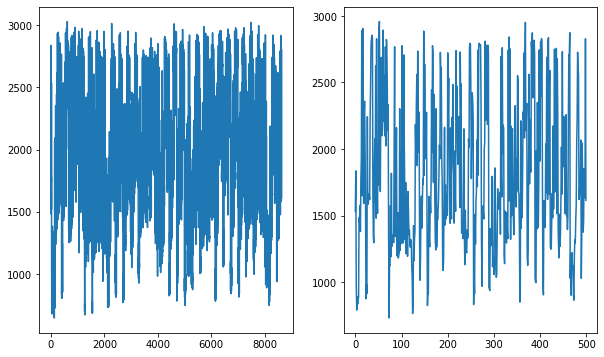

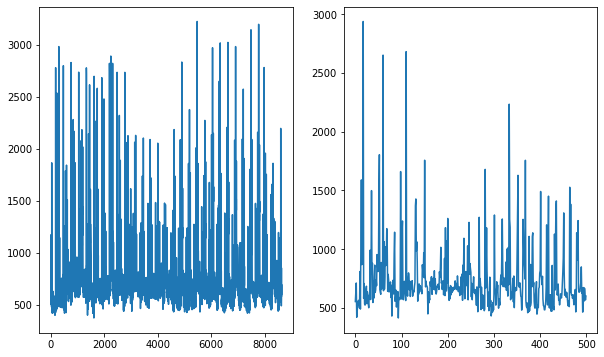

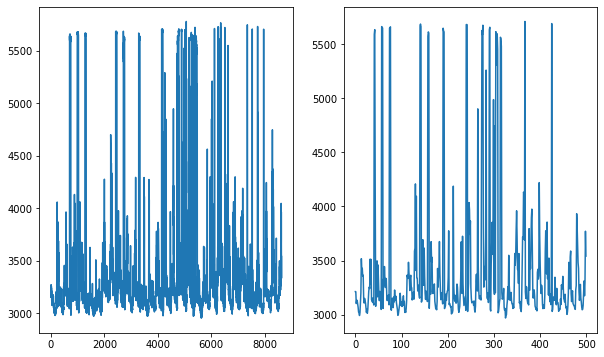

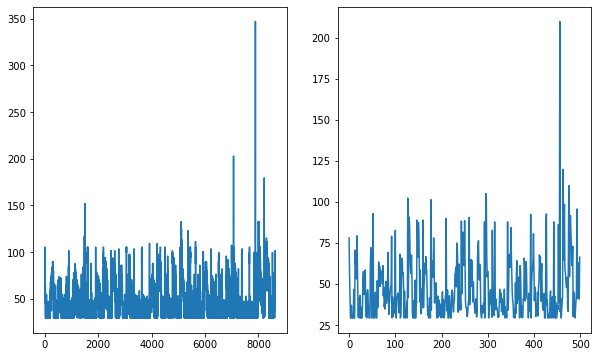

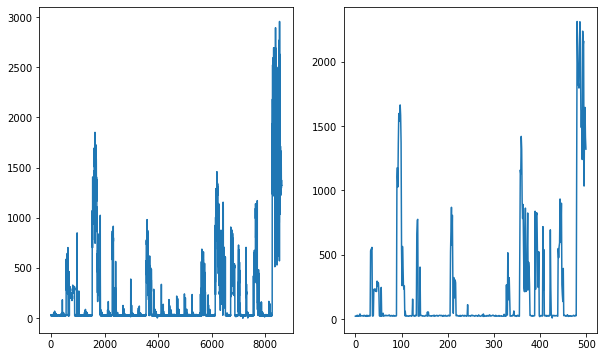

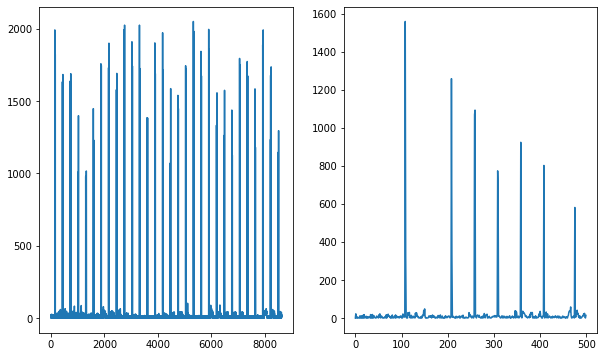

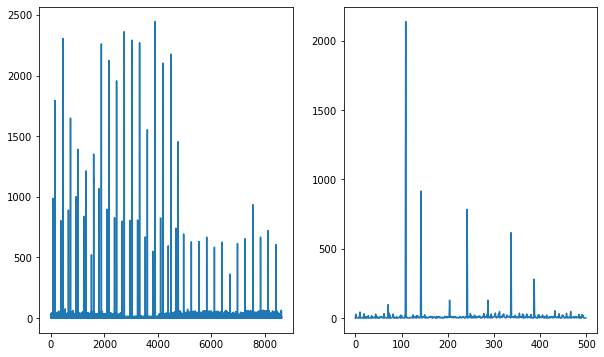

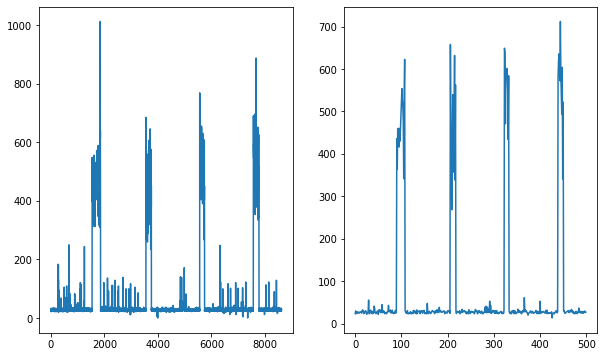

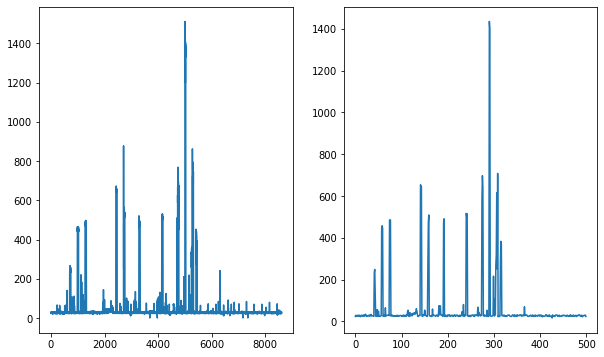

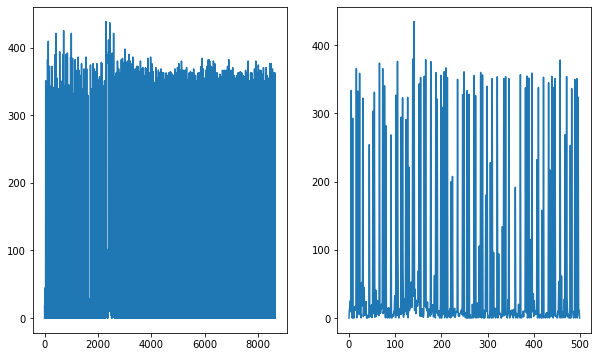

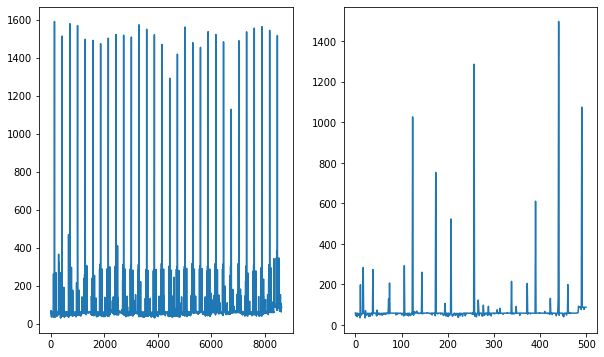

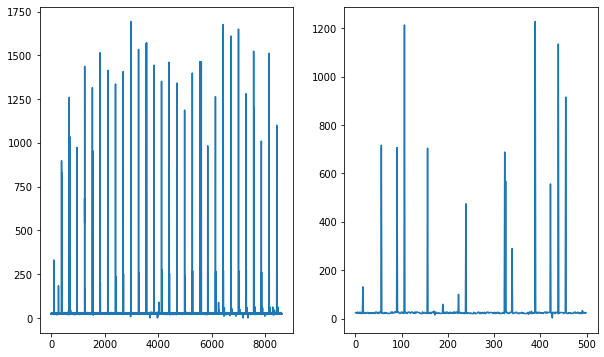

In [133]:
%matplotlib inline
# Take a look at shorten series
for idx,VM in enumerate(VMs_fs):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.plot(Vms_ts[idx].ravel())
    plt.title('Original Time Series')
    plt.subplot(1,2,2)
    plt.plot(VM_short[idx].ravel())
    plt.title('Shorten Time Series')
# plt.legend()

## Playing

In [51]:
VM_name = '1.csv'
VM_path = os.path.join(DATA_PATH, VM_name)
# Read time series of each Virtual Machine (VM)
VM = pd.read_csv(VM_path, sep=';\t', engine='python')